Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
 deer truck horse plane


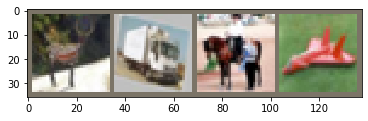

In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from models.VGG16_with_flex_v8 import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [2]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
# Load the pretrained model
state = torch.load('./models/VGG16-flex-v5-block1-model_150_90.pth')
model.load_state_dict(state['model'])
state_dict = model.state_dict()
thr = state_dict["block1.3.threshold1"]
state_dict["block1.3.threshold1"] = Variable(thr.data.new(1, 64, 30, 30).normal_(0.5,std=0.1)) # make a random tensor of same type and device as original
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad = False
for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        m.threshold1.requires_grad = True

if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma = 0.7)

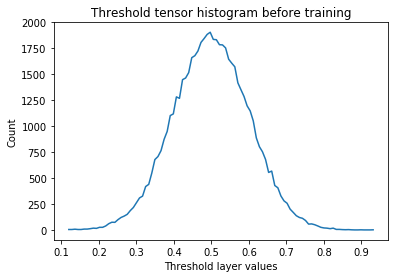

In [3]:
#Plot the initial learned distribution

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        
        thresh_hist = torch.histc(m.threshold1.data)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold tensor histogram before training')
        plt.ylabel('Count')
        plt.xlabel('Threshold layer values')

In [4]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
  correct = 0
  total = 0
  model.train(False)
  with torch.no_grad():
    for i,(images,labels)in enumerate(testloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = model(Variable(images))
      labels = Variable(labels)
      _,predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted.eq(labels)).sum().item()
    print('Test accuracy: %d %%' % (
  100 * correct / total))
  return 100*(correct/total)

#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Test accuracy: 62 %
62.949999999999996
Accuracy of plane : 72 %
Accuracy of   car : 75 %
Accuracy of  bird : 55 %
Accuracy of   cat : 79 %
Accuracy of  deer : 77 %
Accuracy of   dog : 56 %
Accuracy of  frog : 47 %
Accuracy of horse : 75 %
Accuracy of  ship : 62 %
Accuracy of truck : 58 %


In [5]:
#Check if requires grad

for name, param in model.named_parameters():
    if param.requires_grad:
        #print('Yes')
        #print (name, param.data)
        print (name)

block1.3.threshold1


<Figure size 432x288 with 0 Axes>

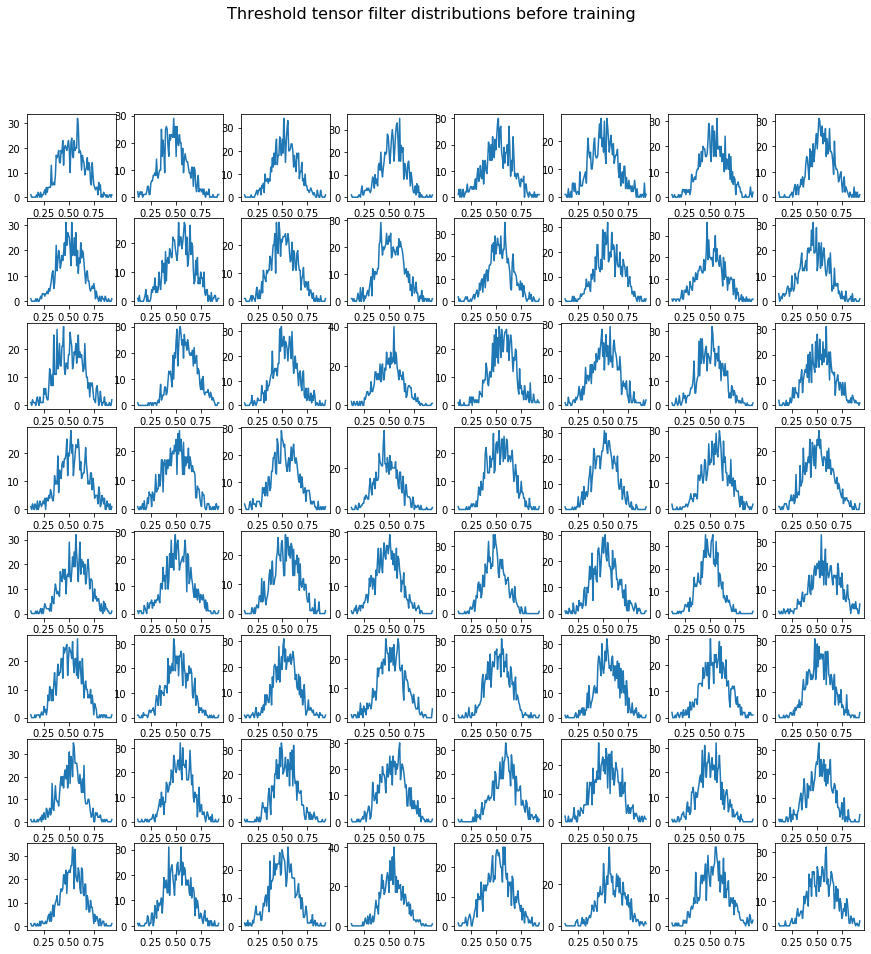

In [6]:
#Plot initial threshold distribution

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
            
        fig2 = plt.figure()
        plt.figure(figsize=(15,15))
        plt.suptitle('Threshold tensor filter distributions before training', fontsize = 16)
        for idx2, filt  in enumerate(m.threshold1[0,:,:,:]):
            thresh_hist = torch.histc(filt)
            plt.subplot(8,8, idx2 + 1)
            plt.plot(xhist, thresh_hist.cpu().detach().numpy())

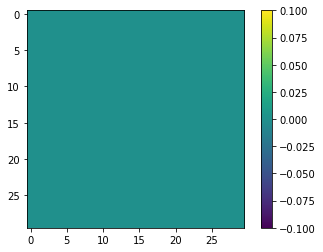

In [7]:
#before training
memorized = []
for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        memorized = m.threshold1.clone()
        imgplot = plt.imshow(m.threshold1.cpu().detach().numpy()[0,1,:] - memorized.cpu().detach().numpy()[0,1,:])
        plt.colorbar()

In [8]:
#======================================================= Training =========================================================================
num_epochs = 10  # Train for 150 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs+1):
  model.train(True)
  epoch_loss  = 0
  i_count = 0
  acc_total = 0
  for i,(images,labels) in enumerate(trainloader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    labels = Variable(labels)
    optimizer.zero_grad()
    outputs = model(Variable(images))
    loss = criterion(outputs,labels)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    _,predicted = outputs.max(1)
    denom = labels.size(0)
    correct = predicted.eq(labels).sum().item()
    acc = 100*(correct/denom)
    acc_total += acc
    i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
  schedule.step()
  train_loss.append(epoch_loss)
  print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
  print('\n')
  test_acc = test()      # Print the test accuracy per epoch
  test_accuracy.append(test_acc)
  
  if(epoch%50 == 0):       # Save the model every 50 epoch
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    #path = './models/VGG16-flex-v5-block1-TEST-' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    #torch.save(state,path)


Epoch:  0   Loss:  636.1622486114502   Train Accuracy : 71.878


Test accuracy: 72 %
Epoch:  1   Loss:  577.6169031858444   Train Accuracy : 74.296


Test accuracy: 74 %
Epoch:  2   Loss:  517.8848160505295   Train Accuracy : 76.694


Test accuracy: 76 %
Epoch:  3   Loss:  456.87942454218864   Train Accuracy : 79.258


Test accuracy: 77 %
Epoch:  4   Loss:  406.4994056224823   Train Accuracy : 81.42


Test accuracy: 79 %
Epoch:  5   Loss:  363.67035549879074   Train Accuracy : 83.304


Test accuracy: 80 %
Epoch:  6   Loss:  334.54758673906326   Train Accuracy : 84.736


Test accuracy: 80 %
Epoch:  7   Loss:  309.7818452566862   Train Accuracy : 85.934


Test accuracy: 81 %
Epoch:  8   Loss:  280.78235755860806   Train Accuracy : 87.334


Test accuracy: 82 %
Epoch:  9   Loss:  258.7617960423231   Train Accuracy : 88.344


Test accuracy: 83 %
Epoch:  10   Loss:  236.70890429615974   Train Accuracy : 89.342


Test accuracy: 83 %


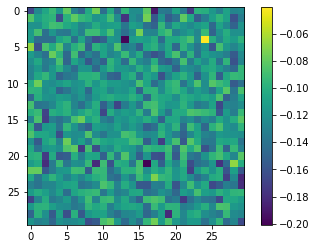

In [9]:
#after training
for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        imgplot = plt.imshow(m.threshold1.cpu().detach().numpy()[0,1,:] - memorized.cpu().detach().numpy()[0,1,:])
        plt.colorbar()

In [10]:
#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Test accuracy: 83 %
83.78
Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 73 %
Accuracy of   cat : 67 %
Accuracy of  deer : 87 %
Accuracy of   dog : 71 %
Accuracy of  frog : 86 %
Accuracy of horse : 93 %
Accuracy of  ship : 89 %
Accuracy of truck : 96 %


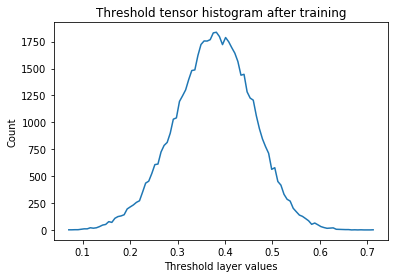

In [11]:
#Plot the new learned distribution

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        
        thresh_hist = torch.histc(m.threshold1)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold tensor histogram after training')
        plt.ylabel('Count')
        plt.xlabel('Threshold layer values')

<Figure size 432x288 with 0 Axes>

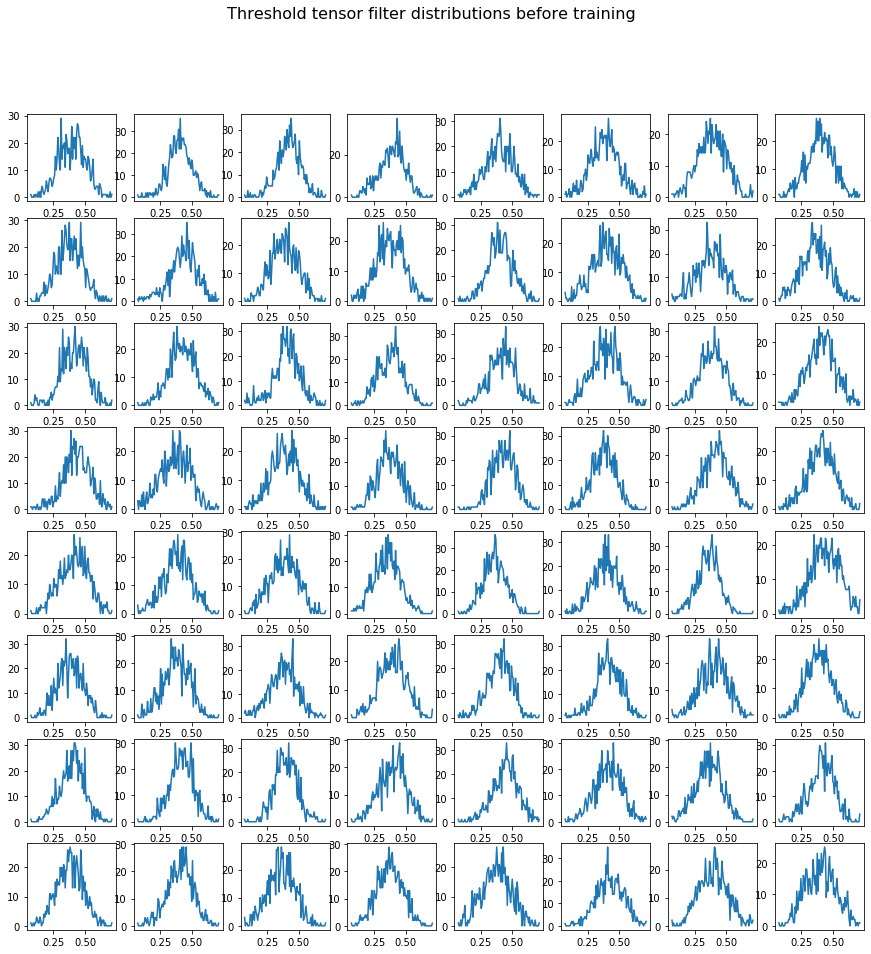

In [12]:
#Plot after training threshold distributions

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
            
        fig2 = plt.figure()
        plt.figure(figsize=(15,15))
        plt.suptitle('Threshold tensor filter distributions before training', fontsize = 16)
        for idx2, filt  in enumerate(m.threshold1[0,:,:,:]):
            thresh_hist = torch.histc(filt)
            plt.subplot(8,8, idx2 + 1)
            plt.plot(xhist, thresh_hist.cpu().detach().numpy())